In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
df_jkse = pd.read_csv('jkse.csv', parse_dates=["Date"], index_col="Date")
df_jkse.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,6197.871094,6205.895020,6164.833984,6181.174805,6181.174805,52797800.0
2019-01-03,6176.151855,6221.009766,6176.151855,6221.009766,6221.009766,72166700.0
2019-01-04,6211.096191,6274.540039,6200.854004,6274.540039,6274.540039,80858100.0
2019-01-07,6317.625977,6354.757813,6287.224121,6287.224121,6287.224121,90278300.0
2019-01-08,6292.263184,6316.240234,6251.375977,6262.847168,6262.847168,90537400.0


In [11]:
df_jkse = df_jkse.drop(columns=['Open','High','Low','Adj Close','Volume'])
df_jkse = df_jkse.rename(columns={'Close': 'JKSE'})
df_jkse.head()

,JKSE
Date,
2019-01-02,6181.174805
2019-01-03,6221.009766
2019-01-04,6274.540039
2019-01-07,6287.224121
2019-01-08,6262.847168


In [12]:
df_jkse['JKSE'] = pd.Series(np.log(df_jkse['JKSE'])).diff()
df_jkse.dropna(inplace=True)


In [13]:
df_jkse

,JKSE
Date,
2019-01-03,0.006424
2019-01-04,0.008568
2019-01-07,0.002019
2019-01-08,-0.003885
2019-01-09,0.001498
...,...
2021-12-16,-0.004759
2021-12-17,0.001081
2021-12-20,-0.008338


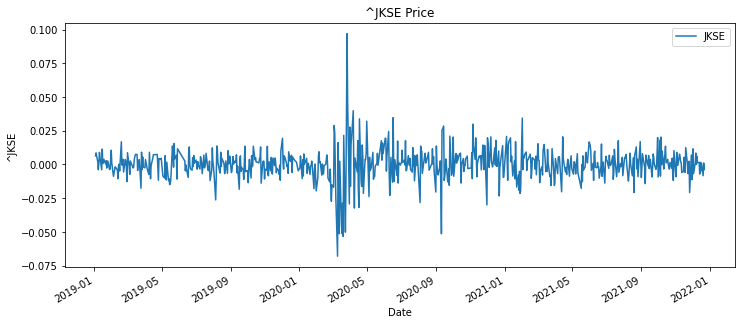

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df_jkse.plot(figsize=(12,5))
plt.title('^JKSE Price')
plt.xlabel("Date")
plt.ylabel("^JKSE")
plt.show()

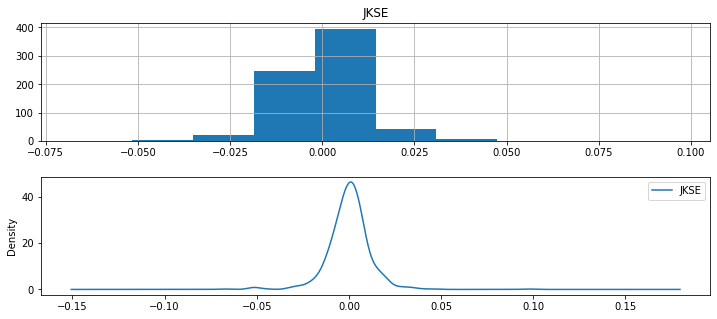

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(12,5))
df_jkse.hist(ax=ax1)
df_jkse.plot(kind='kde', ax=ax2)
plt.show()

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

jkse_ts = pd.Series(df_jkse['JKSE'].values, index=df_jkse)
decomposition = seasonal_decompose(df_jkse['JKSE'], period=52, model='additive')
plt.rcParams['figure.figsize'] = 12, 5
decomposition.plot()
plt.xlabel("Date")
plt.show()

ValueError: Index data must be 1-dimensional

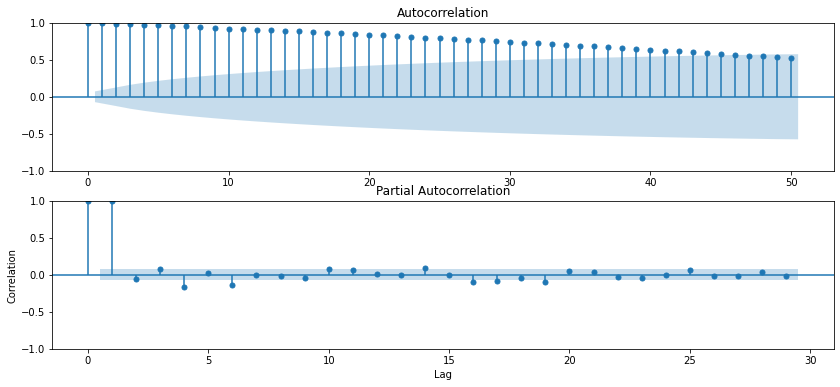

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(jkse_ts, lags=50, ax=ax1)
ax2 = plot_pacf(jkse_ts, ax=ax2)
plt.ylabel("Correlation")
plt.xlabel("Lag")
plt.show()

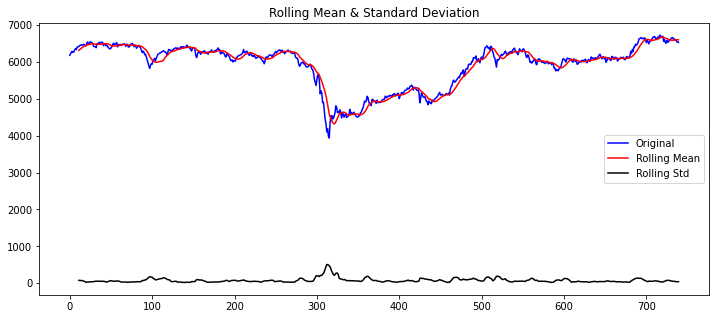

In [10]:
#Determing rolling statistics
rolmean = pd.Series(df_jkse['JKSE']).rolling(window=12).mean()
rolstd = pd.Series(df_jkse['JKSE']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df_jkse['JKSE'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [11]:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
jkse_test = adfuller(jkse_ts.values)

jkse_output = pd.Series(jkse_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in jkse_test[4].items():
    jkse_output['Critical Value (%s)'%key] = value
print(jkse_output)

Results of Dickey-Fuller Test:
Test Statistic                  -1.701923
p-value                          0.430122
#Lags Used                      19.000000
Number of Observations Used    708.000000
Critical Value (1%)             -3.439620
Critical Value (5%)             -2.865631
Critical Value (10%)            -2.568948
dtype: float64


In [12]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num of Lags : ",dftest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Value Calculation : ",dftest[3])
    print("5. Critical Value : ")
    for key, val in dftest[4].items():
        print('\t', key, ': ',val)

    if dftest[0] < dftest[4]['5%']:
        print("Data is Stationary")
    else:
        print("Data is not-Stationary")

In [27]:
ad_test(df_jkse['JKSE'])

1. ADF :  -1.7019225687241413
2. P-Value :  0.4301221848523228
3. Num of Lags :  19
4. Num of Observations Used for ADF Regression and Critical Value Calculation :  708
5. Critical Value : 
	 1% :  -3.439620010600208
	 5% :  -2.8656309041017756
	 10% :  -2.5689484851894413
Data is not-Stationary


In [13]:
import pmdarima as pm
model = pm.auto_arima(jkse_ts, d=1, D=1,
                      seasonal=True, m=52, start_p=0, start_q=0,
                      max_order=6, test='adf', stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=62.94 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=8027.037, Time=13.87 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=7845.777, Time=31.08 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=82.38 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=8028.790, Time=2.17 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=7764.257, Time=140.20 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=423.04 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=95.77 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=7763.571, Time=94.35 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=7845.179, Time=21.16 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=inf, Time=328.47 sec
 ARIMA(0,1,1)(2,1,0)[52]             : AIC=7764.062, Time=125.72 sec
 ARIMA(1,1,1)(2,1,0)[52]             : AIC=7767.033, Time=302.52 sec
 ARIMA(0,1,0)(2,1,0)[52] intercept   : AIC=7765.560, Time=345.56 sec

Best model:  ARIMA(0,1,0

<AxesSubplot:>

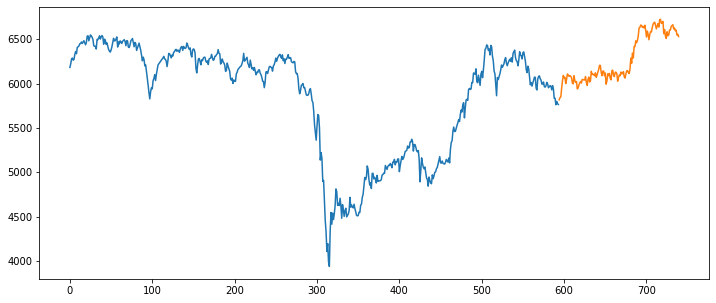

In [14]:
#divide into train and validation set
jkse_train = df_jkse[:int(0.8*(len(jkse_ts)))]
jkse_test = df_jkse[int(0.8*(len(jkse_ts))):]

#plotting the data
jkse_train['JKSE'].plot()
jkse_test['JKSE'].plot()

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(jkse_train['JKSE'],order=(3,1,1),seasonal_order=(2,1,0,52))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                JKSE   No. Observations:                  582
Model:             SARIMAX(3, 1, 1)x(2, 1, [], 52)   Log Likelihood               -3060.652
Date:                             Thu, 30 Dec 2021   AIC                           6135.305
Time:                                     16:25:55   BIC                           6165.202
Sample:                                          0   HQIC                          6147.008
                                             - 582                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5513      0.141      3.915      0.000       0.275       0.827
ar.L2         -0.1053      0.045     -2.323      0.020      -0.194      -0.016
ar.L3          0.1792      0.036      4.916      0.000       0.108       0.251
ma.L1         -0.4848      0.143     -3.383      0.001      -0.766      -0.204
ar.S.L52      -0.6569      0.038    -17.244      0.000      -0.732      -0.582
ar.S.L104     -0.3347      0.038     -8.910      0.000      -0.408      -0.261
sigma2      5901.5186    254.956     23.147      0.000    5401.814    6401.223
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               171.85
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.38   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

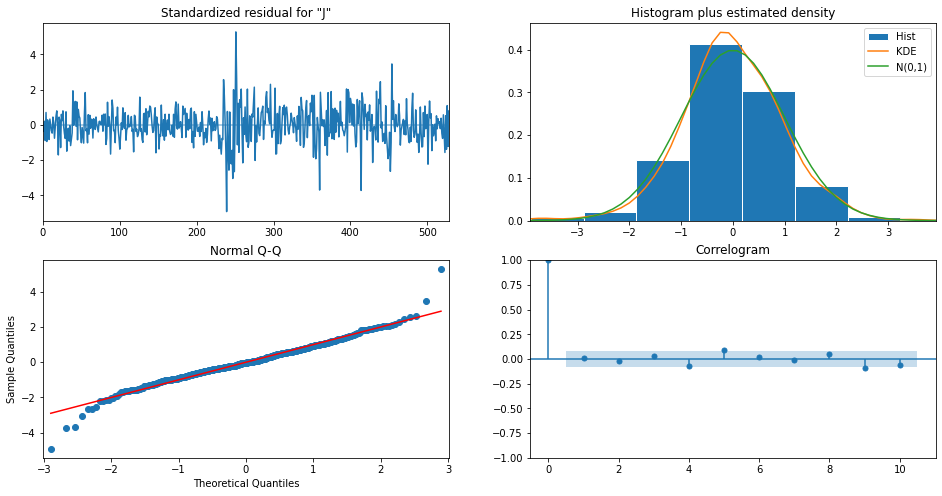

In [16]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

In [17]:
forecast_object = results.get_forecast(steps=len(jkse_test['JKSE']))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

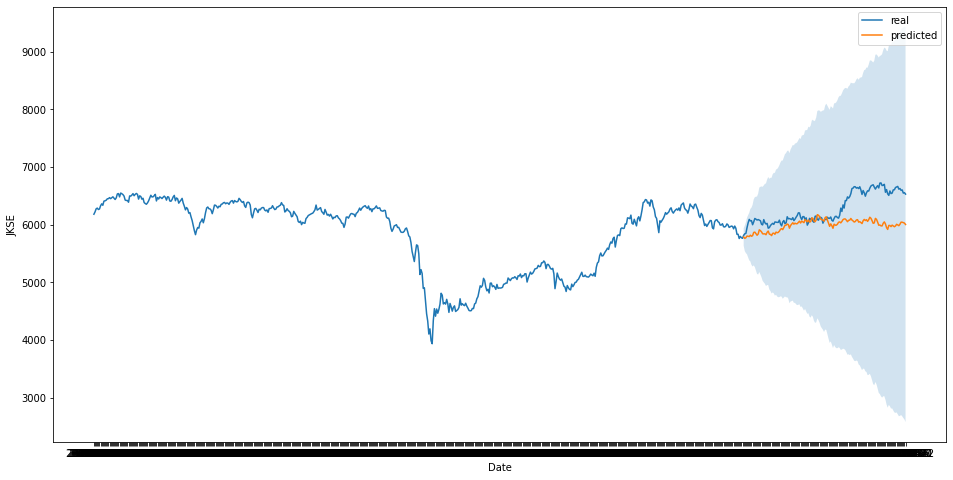

In [18]:
plt.figure(figsize=(16,8))

# Plot past CO2 levels
plt.plot(jkse_ts.index, jkse_ts, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.xlabel("Date")
plt.ylabel("JKSE")
plt.savefig('predtest')
plt.show()

In [19]:
start=len(jkse_train['JKSE'])
end=len(jkse_train['JKSE'])+len(jkse_test['JKSE'])-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMAX(3,1,1)(2,1,0,52) Predictions')

In [22]:
# Compare predictions to expected values
for i in jkse_test.index:
    print(f"predicted={predictions[i]:<11.10}, expected={jkse_test['JKSE'][i]}")

predicted=5816.807769, expected=5815.839844
predicted=5838.316454, expected=5841.828125
predicted=5911.179889, expected=5848.616211
predicted=5896.512576, expected=5947.462891
predicted=5875.364551, expected=6031.578125
predicted=5842.094707, expected=6091.513184
predicted=5840.10036 , expected=6065.166016
predicted=5841.918355, expected=6069.935059
predicted=5825.851543, expected=5999.369141
predicted=5867.844582, expected=6047.475098
predicted=5889.605554, expected=6107.538086
predicted=5836.519672, expected=6095.49707
predicted=5831.055633, expected=6080.383789
predicted=5810.816795, expected=6089.038086
predicted=5849.8208  , expected=6078.567871
predicted=5853.745237, expected=6068.446777
predicted=5834.00203 , expected=6007.120117
predicted=5871.518707, expected=5996.25293
predicted=5859.823658, expected=6087.841797
predicted=5866.60013 , expected=6034.542969
predicted=5888.156352, expected=6012.056152
predicted=5919.511118, expected=6022.398926
predicted=5932.298348, expected=59

KeyError: 728

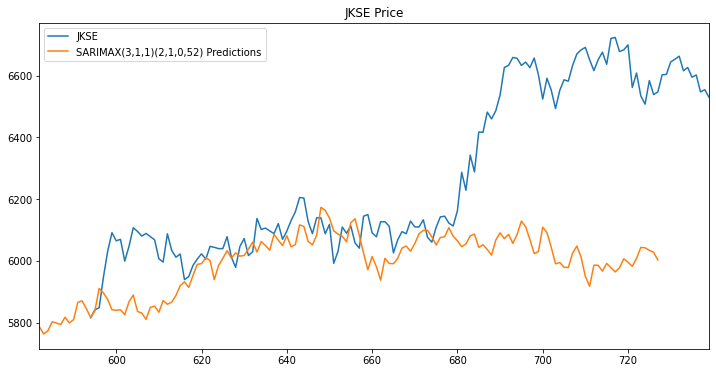

In [23]:
# Plot predictions against known values
title = 'JKSE Price'
ax = jkse_test['JKSE'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

r2_score(jkse_test['JKSE'], predictions)

-0.9280216467658002

In [25]:
import numpy as np

evaluation_results = pd.DataFrame({'r2_score': r2_score(jkse_test['JKSE'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(jkse_test['JKSE'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(jkse_test['JKSE'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - jkse_test['JKSE'])/np.abs(jkse_test['JKSE']))*100 

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,-0.928022,288.014864,134804.023951,3.781375
